In [143]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

### Load Images and Convert to Grayscale

In [215]:
img_r = cv2.imread('IMG_4430.jpg', cv2.IMREAD_GRAYSCALE)
img_l = cv2.imread('IMG_4431.jpg', cv2.IMREAD_GRAYSCALE)

#img_l = cv2.imread('bull/im0.ppm', cv2.IMREAD_GRAYSCALE)
#img_r = cv2.imread('bull/im1.ppm', cv2.IMREAD_GRAYSCALE)

### Find Matching Points

In CV2, there are multiple ways to detect key features. These three are SIFT, SURF, and ORB. SIFT and SURF are patented so not free for commercial use, while ORB is free.SIFT and SURF detect more features then ORB, but ORB is faster.

from: https://pysource.com/2018/03/21/feature-detection-sift-surf-obr-opencv-3-4-with-python-3-tutorial-25/

In [216]:
SIFT = cv2.SIFT_create()
keypoints_l = SIFT.detect(img_l, None)
keypoints_r = SIFT.detect(img_r, None)

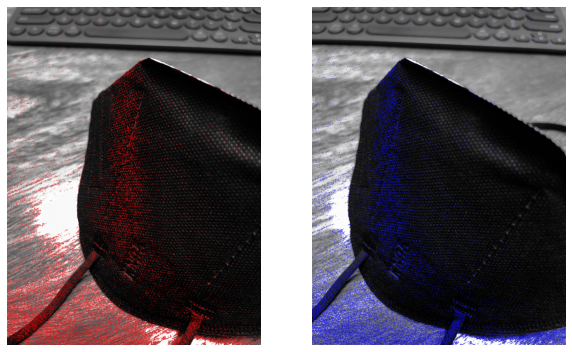

In [217]:
output_image1 = cv2.drawKeypoints(img_l, keypoints_l, img_l, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
output_image2 = cv2.drawKeypoints(img_r, keypoints_r, img_r, (0, 0, 255), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)

plt.figure(figsize = (10,20))
plt.subplot(121)
plt.imshow(output_image1)
plt.axis('off')

plt.subplot(122)
plt.imshow(output_image2)
plt.axis('off')
plt.show()

In [218]:
kpl, desl = SIFT.detectAndCompute(img_l, None)
kpr, desr = SIFT.detectAndCompute(img_r, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)


flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(desl,desr,k=2)

matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kpr[m.trainIdx].pt)
        pts1.append(kpl[m.queryIdx].pt)

print(len(matches))
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask[:100],
                   flags=cv2.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv2.drawMatchesKnn(img_l, kpl, img_r, kpr, matches[:100], None, **draw_params)

44570


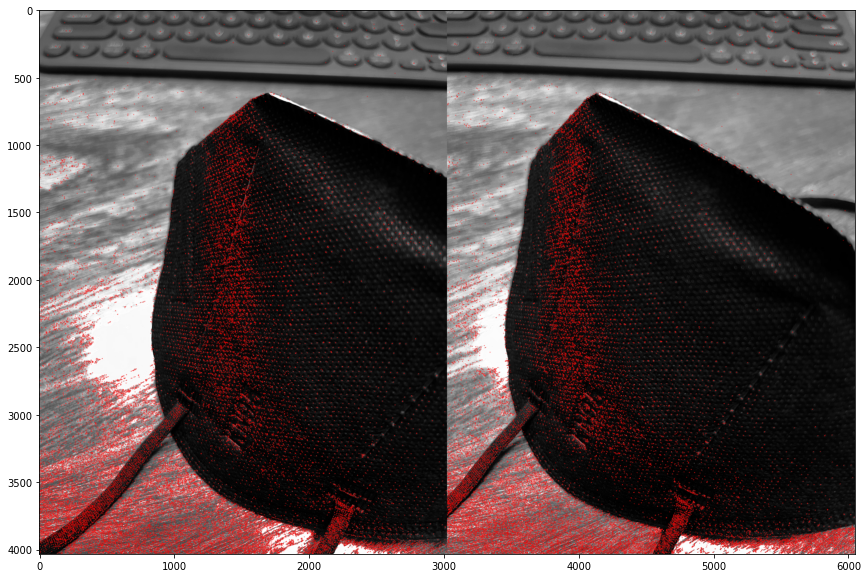

In [219]:
plt.figure(figsize = (20,10))
plt.imshow(keypoint_matches)
plt.show()

### Estimate Fundamental Matrix

In [220]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)
  
# We select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

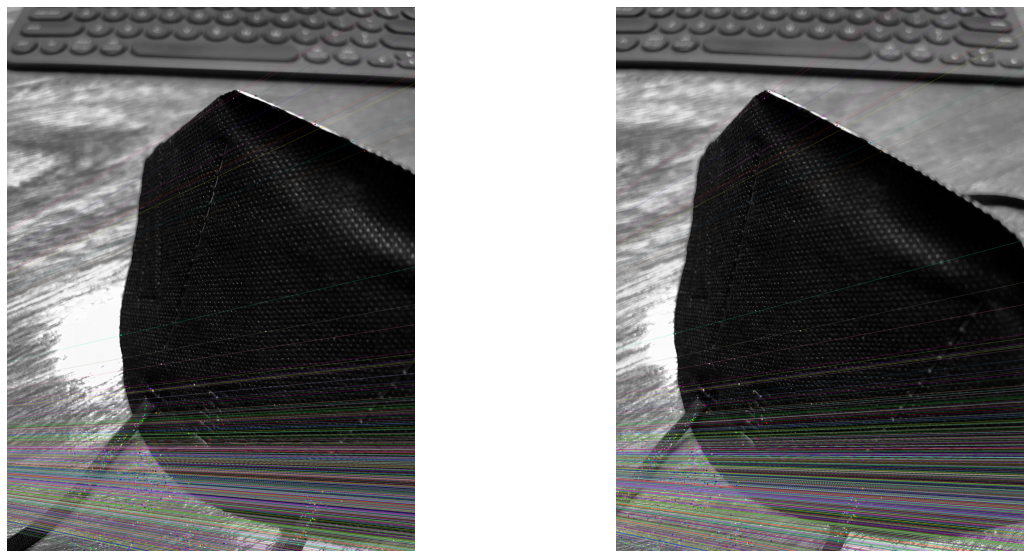

In [221]:
def drawlines(img1src, img2src, lines, pts1src, pts2src):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1src.shape
    img1color = cv2.cvtColor(img1src, cv2.COLOR_GRAY2BGR)
    img2color = cv2.cvtColor(img2src, cv2.COLOR_GRAY2BGR)
    # Edit: use the same random seed so that two images are comparable!
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv2.line(img1color, (x0, y0), (x1, y1), color, 1)
        img1color = cv2.circle(img1color, tuple(pt1), 5, color, -1)
        img2color = cv2.circle(img2color, tuple(pt2), 5, color, -1)
    return img1color, img2color


# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
linesLeft = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
linesLeft = linesLeft.reshape(-1, 3)
img5, img6 = drawlines(img_l, img_r, linesLeft, pts1, pts2)

linesRight = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
linesRight = linesRight.reshape(-1, 3)
  
img3, img4 = drawlines(img_r, img_l, linesRight, pts2, pts1)
   
plt.figure(figsize = (20,10))
plt.subplot(121)
plt.imshow(img5)
plt.axis('off')

plt.subplot(122)
plt.imshow(img3)
plt.axis('off')
plt.show()

### Rectify Images

In [222]:
# Stereo rectification (uncalibrated variant)
# Adapted from: https://stackoverflow.com/a/62607343
h1, w1 = img_l.shape
h2, w2 = img_r.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1))

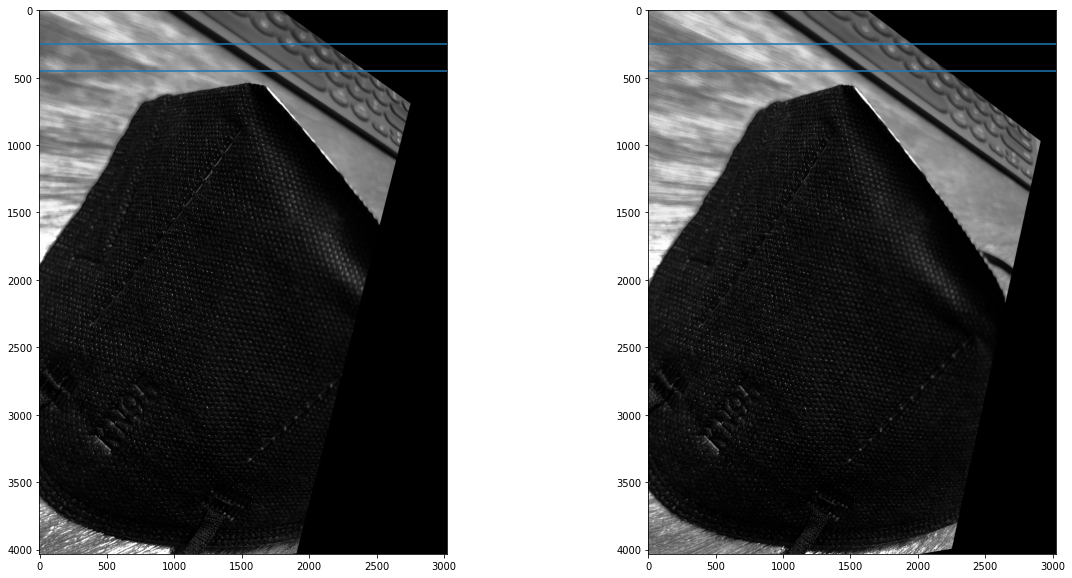

In [223]:
imgl_rectified = cv2.warpPerspective(img_l, H1, (w1, h1))
imgr_rectified = cv2.warpPerspective(img_r, H2, (w2, h2))

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(imgl_rectified, cmap="gray")
axes[1].imshow(imgr_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.show()

### Get Disparity Map

In [224]:
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(img_l, img_r)

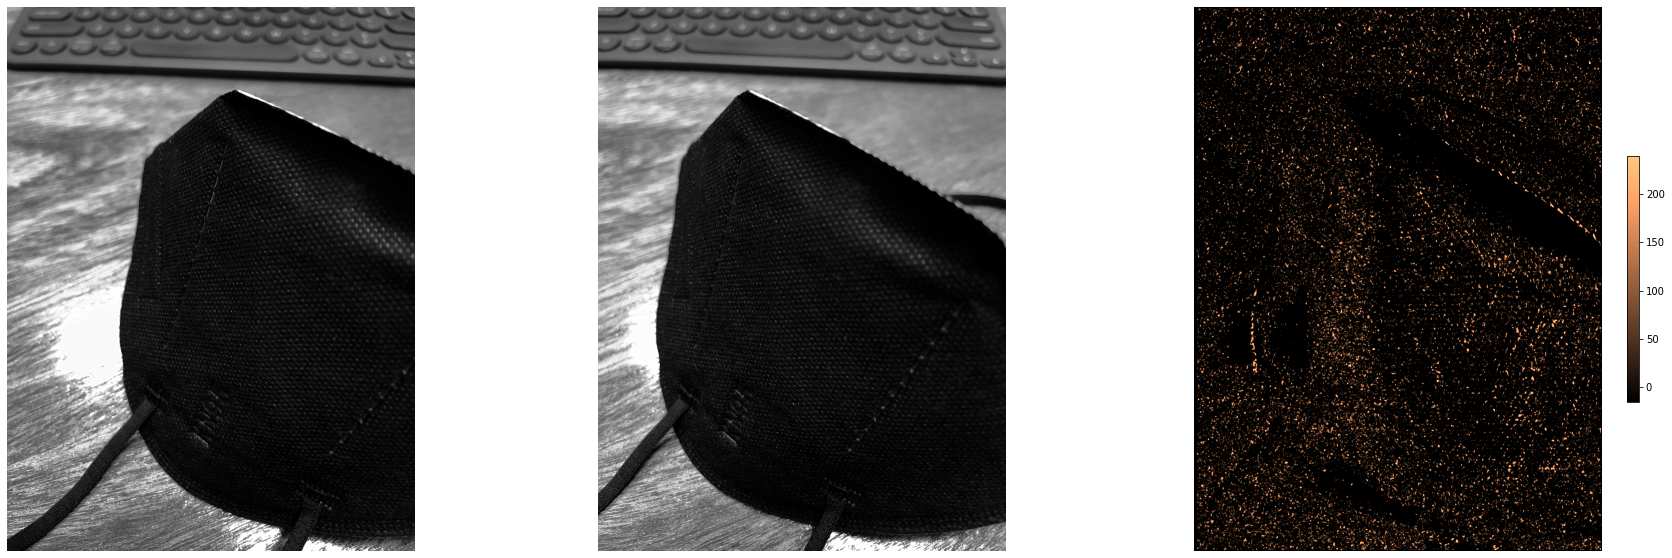

In [225]:
plt.figure(figsize = (30,10))
plt.subplot(131)
plt.imshow(img_l, cmap = 'gray')
plt.axis('off')

plt.subplot(132)
plt.imshow(img_r, cmap = 'gray')
plt.axis('off')

plt.subplot(133)
plt.imshow(disparity, cmap = 'copper')
plt.colorbar(fraction = 0.025)
plt.axis('off')

plt.show()

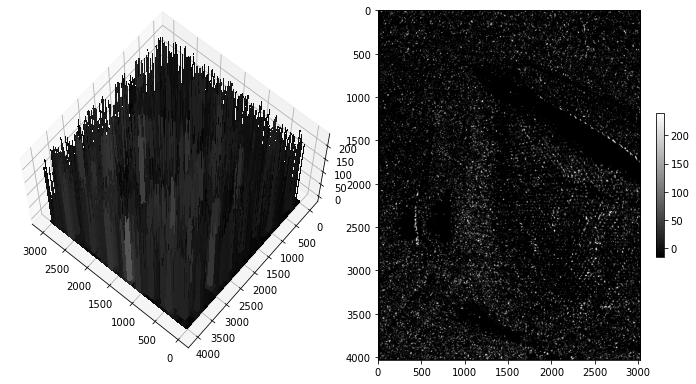

In [226]:
from mpl_toolkits.mplot3d import Axes3D

x = np.arange(0, disparity.shape[1], 1)
y = np.arange(0, disparity.shape[0], 1)

X, Y = np.meshgrid(x,y)
Z = disparity

mappable = plt.cm.ScalarMappable(cmap=plt.cm.gray)
mappable.set_array(Z)

fig = plt.figure(figsize=(10,7))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z, cmap=mappable.cmap, norm=mappable.norm, linewidth=0, antialiased=False)
ax1.view_init(elev= 65, azim = 130)

ax2 = fig.add_subplot(122)
ax2.imshow(Z, cmap=mappable.cmap, norm=mappable.norm)

plt.colorbar(mappable, shrink = 0.3)
plt.tight_layout()

In [228]:
disparity = stereo.compute(imgl_rectified, imgr_rectified)

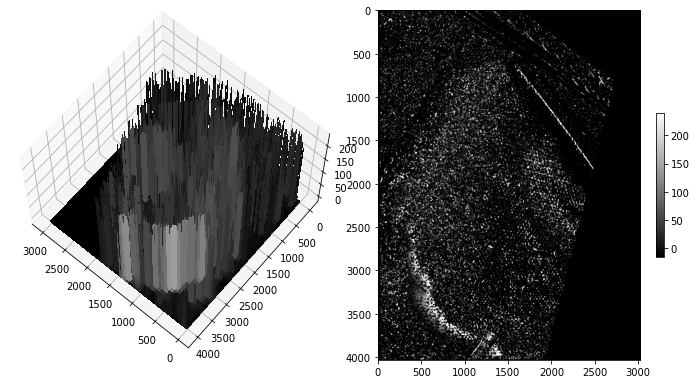

In [229]:
from mpl_toolkits.mplot3d import Axes3D

x = np.arange(0, disparity.shape[1], 1)
y = np.arange(0, disparity.shape[0], 1)

X, Y = np.meshgrid(x,y)
Z = disparity

mappable = plt.cm.ScalarMappable(cmap=plt.cm.gray)
mappable.set_array(Z)

fig = plt.figure(figsize=(10,7))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z, cmap=mappable.cmap, norm=mappable.norm, linewidth=0, antialiased=False)
ax1.view_init(elev= 65, azim = 130)

ax2 = fig.add_subplot(122)
ax2.imshow(Z, cmap=mappable.cmap, norm=mappable.norm)

plt.colorbar(mappable, shrink = 0.3)
plt.tight_layout()